# Incrementing the Observations to Estimate all the Parameters in Fractional Additive SDEs

We consider the following one-dimensional Onrstein-Uhlenbeck process $$dY = -\xi_0 Y_s dt + \sigma_0 dB^{H_0}.$$ We have access to discrete observations of $Y$ of the form $\{Y_{kh}, k=1,2,..\}$ and we want to estimate the parameters $\xi_0,\sigma_0$ and $H_0$. The estimation procedure is based on minimizing the distance:
$$ \theta = (\xi,\sigma,H) \rightarrow d(\frac{1}{n} \sum_1^n \delta_{X_{kh}}, \frac{1}{N} \sum_1^{N} \delta_{L^{\theta}_{k\gamma}})$$
where $d$ is a distance that is bounded by the $p$-Wassertein distance and $$X_. = (Y_., Y_{.+h}-Y_., Y_{.+2h}-Y_.,...,Y_{.+qh}-Y_)$$ is a vector that contains the solution $Y$ and its increments. Similarly, $$L^\theta_.= (M^\theta_., M^\theta_{.+h}-M^\theta_., M^\theta_{.+2h}-M^\theta_.,...,M^\theta_{.+qh}-M^\theta_.)$$ where $M^\theta$ is a simulated O-U process with the parameters $\xi,\sigma$ and $H$ (through a Euler scheme of step size $\gamma$).

## I. Simulation of the fractional Brownian motion

We simulate the fractional Brownian motion using the Davies-Harte method.

In [6]:

import numpy as np
from math import *
import matplotlib.pyplot as plt

def davies_harte(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=complex); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=complex)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path

def fBm(T, N, H, trials):
    """
    Generates multiple sample paths of fractional Brownian Motion using the Davies Harte method.

    Args:
        T (float): Length of time (in years).
        N (int): Number of time steps within the timeframe.
        H (float): Hurst parameter.
        trials (int): Number of sample paths to generate.

    Returns:
        numpy.ndarray: Array containing the generated sample paths.
    """
    B = np.zeros((N + 1, trials))
    for i in range(trials):
        B[:, i] = davies_harte(T, N, H)
    return B  
    

Examples:

/var/folders/hq/21gqnbfx469b81hyspyj0m_h0000gn/T/ipykernel_23074/2670746497.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  B[:,i] = davies_harte(T,N,H)


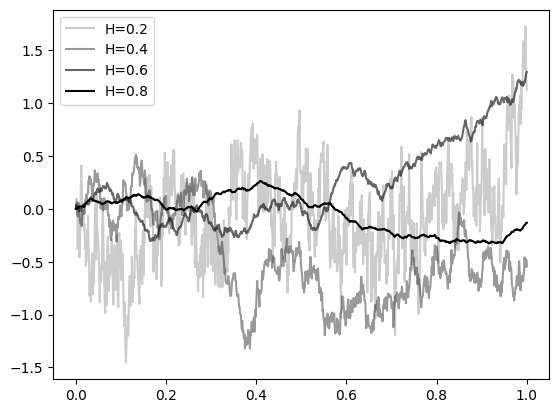

In [8]:
t = np.linspace(0,1,1001)
B08 = fBm(1,1000,0.8,1)
B04 = fBm(1,1000,0.4,1)
B06 = fBm(1,1000,0.6,1)
B02 = fBm(1,1000,0.2,1)
plt.plot(t,B02,color='black', alpha=0.2, label='H=0.2')
plt.plot(t,B04, color='black', alpha=0.4, label='H=0.4')
plt.plot(t,B06, color='black', alpha=0.6, label='H=0.6')
plt.plot(t,B08, color='black', label='H=0.8')
plt.legend()
plt.savefig("fBmpaths.pdf")

## II. Simulation of the fractional O-U process
We simulate the fractional O-U process through a Euler scheme.

In [9]:
def ornstein_uhlenbeck(dt, n, drift, sigma, H):
    """
    Simulates the Ornstein-Uhlenbeck process using the Euler-Maruyama method.

    Args:
        dt (float): Time step size.
        n (int): Number of time steps.
        drift (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        H (float): Hurst parameter for the fractional Brownian motion.

    Returns:
        numpy.ndarray: Simulated path of the Ornstein-Uhlenbeck process.
    """
    T = dt * n  # Total time
    trials = 1  # Number of trials
    B = fBm(T, n, H, trials)  # Generate fractional Brownian motion
    x = np.zeros((n + 1, trials))  # Initialize the process array
    for i in range(n):
        # Update the process using the Euler-Maruyama method
        x[i + 1, :] = x[i, :] - dt * x[i, :] * drift + sigma * (B[i + 1, :] - B[i, :])
    return x[:, 0]  # Return the first trial  

Example:

/var/folders/hq/21gqnbfx469b81hyspyj0m_h0000gn/T/ipykernel_23074/2670746497.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  B[:,i] = davies_harte(T,N,H)


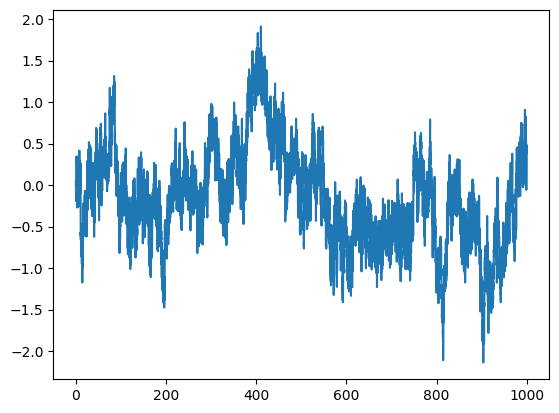

In [10]:
OU1=ornstein_uhlenbeck(0.001,10000,1,1,0.3)
#OU2=ornstein_uhlenbeck(0.001,10000,1,1,0.5)
#R = abs(OU1-OU2)/(0.2**0.9)
t = np.linspace(0,1000,10001)
plt.plot(t,OU1)

## III. Extraction of the sample
Given a set of parameters $\theta$, we extract the associated sample $X^\theta$

In [ ]:
def increments(x, q):
    """
    Computes the increments of a given time series.

    Args:
        x (numpy.ndarray): The input time series.
        q (int): The number of increments to compute.

    Returns:
        numpy.ndarray: A matrix containing the increments.
    """
    n = len(x) - q
    X = np.zeros((n, q))
    for i in range(1, q):
        X[:, i] = x[i:i + n] - x[0:n]
    X[:, 0] = x[0:n]
    return X    


def true_sample(n, q, h, xi, sigma, H):
    """
    Generates a true sample of the Ornstein-Uhlenbeck process.

    Args:
        n (int): Number of observations.
        q (int): Number of increments.
        h (float): Time step size.
        xi (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        H (float): Hurst parameter.

    Returns:
        numpy.ndarray: A matrix containing the true sample and its increments.
    """
    dt = 0.001
    x = ornstein_uhlenbeck(dt, int((n + q) * (h / dt)), xi, sigma, H)
    good_indices = [i for i in range(int((n + q) * (h / dt))) if i % int(1 / h) == 0]
    x = np.array([x[i] for i in good_indices])
    X = increments(x, q)
    return X

def euler_sample(n, q, gamma, xi, sigma, H):
    """
    Generates a sample of the Ornstein-Uhlenbeck process using the Euler-Maruyama method.

    Args:
        n (int): Number of observations.
        q (int): Number of increments.
        gamma (float): Time step size for the Euler-Maruyama method.
        xi (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        H (float): Hurst parameter.

    Returns:
        numpy.ndarray: A matrix containing the Euler-Maruyama sample and its increments.
    """
    x = ornstein_uhlenbeck(gamma, n + q, xi, sigma, H)
    X = increments(x, q)
    return X
    
    

Example:

In [ ]:
#true_sample(100,3,1,1,0.1,0.5)
#euler_sample(10000,3,0.01,1,0.1,0.5)

## VI. Minimization procedure: Estimation of one parameters (Gradient descent)

In [12]:
#Hyper parameters
trials = 100
N = 10000
n = 1000
h = 0.1
timestep = 0.1
xi = 2
sigma = 0.5
H = 0.7
p = 2

In [13]:
def random_va(trials):
    # Generate random uniform variables
    u = np.random.uniform(0, 2 * pi, trials)
    v = np.random.uniform(0, 1, trials)
    # Transform v using the given formula
    v = (v**(1 / (1 - 3)) - 1)**(1 / 2)
    # Initialize result array
    res = np.zeros((2, trials))
    # Calculate the random variables
    res[0, :] = v * np.cos(u)
    res[1, :] = v * np.sin(u)
    return res

def loss_drift(theta, x):
    # Generate Euler samples
    z = euler_sample(N, 2, timestep, theta, sigma, H)
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    # Calculate scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate scalar products for Euler
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    # Calculate average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def oracle_loss_drift(theta, x):
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate variance
    var = (sigma**2) * (H * gamma(2 * H)) * theta**(-2 * H)
    # Calculate average cosine values
    av_cos_euler = np.exp(-var * eta**2 / 2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def loss_hurst(theta, x):
    # Generate Euler samples
    z = euler_sample(N, 2, timestep, xi, sigma, theta)
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    # Calculate scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate scalar products for Euler
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    # Calculate average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def oracle_loss_hurst(theta, x):
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate variance
    var = (sigma**2) * (H * gamma(2 * theta)) * xi**(-2 * theta)
    # Calculate average cosine values
    av_cos_euler = np.exp(-var * eta**2 / 2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def loss_diffusion(theta, x):
    # Generate Euler samples
    z = euler_sample(N, 2, timestep, xi, theta, H)
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    # Calculate scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate scalar products for Euler
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    # Calculate average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def oracle_loss_diffusion(theta, x):
    # Generate random variables
    eta = random_va(100)
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    # Calculate variance
    var = (theta**2) * (H * gamma(2 * H)) * xi**(-2 * H)
    # Calculate average cosine values
    av_cos_euler = np.exp(-var * eta**2 / 2)
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    # Calculate the difference
    diff = av_cos_sample - av_cos_euler
    # Return the loss
    return 10 * np.mean(diff**2)

def grad_drift(theta, delta, x):
    # Calculate gradient using finite differences
    grad = (loss_drift(theta + delta, x) - loss_drift(theta, x)) / delta
    return np.array(grad)

def grad_diffusion(theta, delta, x):
    # Calculate gradient using finite differences
    grad = (loss_diffusion(theta + delta, x) - loss_diffusion(theta, x)) / delta
    return np.array(grad)

def grad_hurst(theta, delta, x):
    # Calculate gradient using finite differences
    grad = (loss_hurst(theta + delta, x) - loss_hurst(theta, x)) / delta
    return np.array(grad)

def oracle_grad_drift(theta, delta, x):
    # Calculate oracle gradient using finite differences
    grad = (oracle_loss_drift(theta + delta, x) - oracle_loss_drift(theta, x)) / delta
    return np.array(grad)

def oracle_grad_diffusion(theta, delta, x):
    # Calculate oracle gradient using finite differences
    grad = (oracle_loss_diffusion(theta + delta, x) - oracle_loss_diffusion(theta, x)) / delta
    return np.array(grad)

def oracle_grad_hurst(theta, delta, x):
    # Calculate oracle gradient using finite differences
    grad = (oracle_loss_hurst(theta + delta, x) - oracle_loss_hurst(theta, x)) / delta
    return np.array(grad)

def descent_drift(step, delta, x):
    # Initial guess
    v0 = np.array([1.5])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate gradient
        jac = grad_drift(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_drift(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_drift(v, delta, x)
        if jac == nan:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        if v < 0:
            v = v0
        #print(jac, v, loss_drift(v, x))
    return v

def descent_hurst(step, delta, x):
    # Initial guess
    v0 = np.array([0.6])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate gradient
        jac = grad_hurst(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_hurst(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_hurst(v, delta, x)
        if jac == nan:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        if v < 0 or v > 1:
            v = v0
        #print(jac, v, loss_drift(v, x))
    return v

def descent_diffusion(step, delta, x):
    # Initial guess
    v0 = np.array([0.7])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate gradient
        jac = grad_diffusion(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = grad_diffusion(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_diffusion(v, delta, x)
        if jac == nan:
            v = v0
        if v < 0:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        #print(jac, v, loss_drift(v, x))
    return v

def oracle_descent_drift(step, delta, x):
    # Initial guess
    v0 = np.array([1.5])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate oracle gradient
        jac = oracle_grad_drift(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_drift(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_drift(v, delta, x)
        if jac == nan:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        if v < 0:
            v = v0
        #print(jac, v, oracle_loss_drift(v, x))
    return v

def oracle_descent_hurst(step, delta, x):
    # Initial guess
    v0 = np.array([0.65])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate oracle gradient
        jac = oracle_grad_hurst(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_hurst(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_hurst(v, delta, x)
        if jac == nan:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        if v < 0 or v > 1:
            v = v0
        #print(jac, v, oracle_loss_hurst(v, x))
    return v

def oracle_descent_diffusion(step, delta, x):
    # Initial guess
    v0 = np.array([0.7])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Calculate oracle gradient
        jac = grad_diffusion(v, delta, x)
        timer = 0
        # Adjust gradient if too large
        while np.abs(jac) > 1:
            timer += 1
            jac = oracle_grad_diffusion(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_diffusion(v, delta, x)
        if jac == nan:
            v = v0
        if v < 0:
            v = v0
        # Update parameter
        v = v - step * jac * (i + 1)**(-1)
        #print(jac, v, oracle_loss_diffusion(v, x))
    return v

In [ ]:
def estimator_drift(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the drift parameter
        res = descent_drift(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the drift parameter
        res_oracle = oracle_descent_drift(2, 1e-1, x)
        
        # Store the results
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    
    # Plot histograms of the oracle and estimated values
    plt.hist(oracle, bins=15, histtype='barstacked', color='gray', label='oracle')
    plt.hist(estimates, bins=15, histtype='barstacked', color='#FF000000', ec='darkgray', hatch='/', label='estimate')
    
    # Plot vertical lines for the means
    plt.axvline(np.mean(estimates), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
    plt.axvline(2, color='k', linewidth=1)
    
    # Add title and legend
    plt.title('Drift estimation', fontweight="bold", fontsize=10)
    plt.legend()
    
    # Save the plot
    plt.savefig("histdrift2.pdf")
    
    # Print the empirical mean and variance of the estimates and oracle values
    print('empirical mean = ', np.mean(estimates), 'empirical variance= ', np.var(estimates)) 
    print('oracle mean = ', np.mean(oracle), 'oracle variance= ', np.var(oracle)) 

In [ ]:
#Example
estimator_drift(20)

In [ ]:
def estimator_hurst(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the Hurst parameter
        res = descent_hurst(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the Hurst parameter
        res_oracle = oracle_descent_hurst(2, 1e-1, x)
        
        # Store the results
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    
    # Plot histograms of the oracle and estimated values
    plt.hist(oracle, bins=15, histtype='barstacked', color='gray', label='oracle')
    plt.hist(estimates, bins=15, histtype='barstacked', color='#FF000000', ec='darkgray', hatch='/', label='estimate')
    
    # Plot vertical lines for the means
    plt.axvline(np.mean(estimates), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
    plt.axvline(0.7, color='k', linewidth=1)
    
    # Add title and legend
    plt.title('Hurst estimation', fontweight="bold", fontsize=10)
    plt.legend()
    
    # Save the plot
    plt.savefig("histhurst2.pdf")
    
    # Print the empirical mean and variance of the estimates and oracle values
    print('empirical mean = ', np.mean(estimates), 'empirical variance= ', np.var(estimates)) 
    print('oracle mean = ', np.mean(oracle), 'oracle variance= ', np.var(oracle))
    


In [ ]:
#Example
estimator_hurst(40)  

In [ ]:
def estimator_diffusion(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros(trials)
    oracle = np.zeros(trials)
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the diffusion parameter
        res = descent_diffusion(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the diffusion parameter
        res_oracle = oracle_descent_diffusion(2, 1e-1, x)
        
        # Store the results
        oracle[trial] = res_oracle[0]
        estimates[trial] = res[0]
    
    # Plot histograms of the oracle and estimated values
    plt.hist(oracle, bins=15, histtype='barstacked', color='gray', label='oracle')    
    plt.hist(estimates, bins=15, histtype='barstacked', color='#FF000000', ec='darkgray', hatch='/', label='estimate')
    
    # Plot vertical lines for the means
    plt.axvline(np.mean(estimates), color='darkgray', linestyle=(5, (10, 3)), linewidth=1, label='estimate-mean')
    plt.axvline(np.mean(oracle), color='gray', linestyle='-.', linewidth=2, label='oracle-mean')
    plt.axvline(0.5, color='k', linewidth=1)
    
    # Add title and legend
    plt.title('Diffusion estimation', fontweight="bold", fontsize=10)
    plt.legend()
    
    # Save the plot
    plt.savefig("histdiffusion2.pdf")
    
    # Print the empirical mean and variance of the oracle values
    print('empirical mean = ', np.mean(oracle), 'empirical variance= ', np.var(oracle)) 

In [ ]:
#Example
estimator_diffusion(20)  

## Two parameters estimation (comparison between oracle and approximation) 


In [ ]:
from scipy.special import psi
from scipy.special import gamma
import scipy.integrate as integrate

def cov_matrix(xi,H,sigma):
    # Integrate to find the value of I
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    
    # Calculate non-diagonal and diagonal elements of the covariance matrix
    non_diag = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  - (sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)
    diag_1 = (sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)
    diag_2 = 2*(sigma**2)*(H*gamma(2*H) )*(1/xi)**(2*H)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  
    
    # Create the covariance matrix
    cov = np.zeros((2,2))
    cov[0,0]=diag_1
    cov[1,1]=diag_2
    cov[0,1]= non_diag
    cov[1,0] = non_diag
    
    return cov

def partial_cov(xi,H,sigma):
    # Integrate to find the value of I
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    
    # Calculate partial derivatives with respect to sigma
    non_diag = 2*(sigma)*gamma(2*H+1)*sin(pi*H)*I/pi  - (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_1 = (2*sigma)*(H*gamma(2*H) )*xi**(-2*H)
    diag_2 = 2*(2*sigma)*(H*gamma(2*H) )*xi**(-2*H)-2*(2*sigma)*gamma(2*H+1)*sin(pi*H)*I/pi  
    cov_sigma =  [[diag_1, non_diag],[non_diag,diag_2]]
    
    # Integrate to find the value of I for xi
    I = integrate.quad(lambda x: -cos(h*x)*(x**(1-2*H))*(2*xi)/(xi**2 + x**2)**2, 0, 1000)
    I = I[0]
    
    # Calculate partial derivatives with respect to xi
    non_diag = (sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  - (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_1 = (-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)
    diag_2 = 2*(-2*H)*(sigma**2)*(H*gamma(2*H) )*xi**(-2*H-1)-2*(sigma**2)*gamma(2*H+1)*sin(pi*H)*I/pi  
    cov_xi =  [[diag_1, non_diag],[non_diag,diag_2]]
    
    # Integrate to find the value of I and II for H
    I = integrate.quad(lambda x: cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    I = I[0]
    II = integrate.quad(lambda x: (-2*log(x))*cos(h*x)*(x**(1-2*H))/(xi**2 + x**2), 0, 1000)
    II = II[0]
    
    # Calculate partial derivatives with respect to H
    non_diag = (sigma**2)*gamma(2*H+1)*cos(pi*H)*I + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II/pi  - (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) - (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_1 = (sigma**2)*(psi(2*H+1)*gamma(2*H+1))*xi**(-2*H) + (-2*log(xi))*(sigma**2)*(gamma(2*H+1)/2)*xi**(-2*H)
    diag_2 = 2*diag_1 -2*( (sigma**2)*gamma(2*H+1)*cos(pi*H)*I + 2*(sigma**2)*psi(2*H+1)*gamma(2*H+1)*sin(pi*H)*I/pi + (sigma**2)*gamma(2*H+1)*sin(pi*H)*II/pi  )
    cov_H =  [[diag_1, non_diag],[non_diag,diag_2]]
    
    return [cov_xi, cov_H, cov_sigma]

from numpy import linalg as LA

def loss_drift_hurst(theta,x):
    # Generate Euler sample
    z = euler_sample(N, 2, timestep, theta[0], sigma, theta[1])
    
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    
    # Compute scalar products for sample and Euler sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    
    # Compute average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def oracle_loss_drift_hurst(theta,x):
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    
    # Compute scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    
    # Compute covariance matrix
    cov = cov_matrix(theta[0], theta[1], sigma)
    
    # Compute average cosine values for Euler sample
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:, tt], np.dot(cov, eta[:, tt]) / 2))
    
    # Compute average cosine values for sample
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def loss_hurst_sigma(theta,x):
    # Generate Euler sample
    z = euler_sample(N, 2, timestep, xi, theta[0], theta[1])
    
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    
    # Compute scalar products for sample and Euler sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    
    # Compute average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def oracle_loss_hurst_sigma(theta,x):
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    
    # Compute scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    
    # Compute covariance matrix
    cov = cov_matrix(xi, theta[1], theta[0])
    
    # Compute average cosine values for Euler sample
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:, tt], np.dot(cov, eta[:, tt]) / 2))
    
    # Compute average cosine values for sample
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def loss_diffusion_drift(theta,x):
    # Generate Euler sample
    z = euler_sample(N, 2, timestep, theta[0], theta[1], H)
    
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    scalar_p_euler = np.zeros((N, trials))
    
    # Compute scalar products for sample and Euler sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1]
    
    # Compute average cosine values
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def oracle_loss_diffusion_drift(theta,x):
    # Generate random variables
    eta = random_va(100)
    
    # Initialize scalar products
    scalar_p_sample = np.zeros((n, trials))
    
    # Compute scalar products for sample
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1]
    
    # Compute covariance matrix
    cov = cov_matrix(theta[0], H, theta[1])
    
    # Compute average cosine values for Euler sample
    av_cos_euler = np.zeros(trials)
    for tt in range(trials):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:, tt], np.dot(cov, eta[:, tt]) / 2))
    
    # Compute average cosine values for sample
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    
    # Compute difference and return loss
    diff = av_cos_sample - av_cos_euler
    return 10 * np.mean(diff**2)

def grad_drift_hurst(theta, delta, x):
    # Compute the gradient with respect to the first parameter
    grad1 = (loss_drift_hurst(np.array([theta[0] + delta, theta[1]]), x) - loss_drift_hurst(theta, x)) / delta
    # Compute the gradient with respect to the second parameter
    grad2 = (loss_drift_hurst(np.array([theta[0], theta[1] + delta]), x) - loss_drift_hurst(theta, x)) / delta
    return np.array([grad1, grad2])

def grad_diffusion_drift(theta, delta, x):
    # Compute the gradient with respect to the first parameter
    grad1 = (loss_diffusion_drift(np.array([theta[0] + delta, theta[1]]), x) - loss_diffusion_drift(theta, x)) / delta
    # Compute the gradient with respect to the second parameter
    grad2 = (loss_diffusion_drift(np.array([theta[0], theta[1] + delta]), x) - loss_diffusion_drift(theta, x)) / delta
    return np.array([grad1, grad2])

def grad_hurst_sigma(theta, delta, x):
    # Compute the gradient with respect to the first parameter
    grad1 = (loss_hurst_sigma(np.array([theta[0] + delta, theta[1]]), x) - loss_hurst_sigma(theta, x)) / delta
    # Compute the gradient with respect to the second parameter
    grad2 = (loss_hurst_sigma(np.array([theta[0], theta[1] + delta]), x) - loss_hurst_sigma(theta, x)) / delta
    return np.array([grad1, grad2])

def oracle_grad_drift_hurst(theta, delta, x):
    # Compute the gradient with respect to the first parameter using the oracle loss function
    grad1 = (oracle_loss_drift_hurst(np.array([theta[0] + delta, theta[1]]), x) - oracle_loss_drift_hurst(theta, x)) / delta
    # Compute the gradient with respect to the second parameter using the oracle loss function
    grad2 = (oracle_loss_drift_hurst(np.array([theta[0], theta[1] + delta]), x) - oracle_loss_drift_hurst(theta, x)) / delta
    return np.array([grad1, grad2])

def oracle_grad_diffusion_drift(theta, delta, x):
    # Compute the gradient with respect to the first parameter using the oracle loss function
    grad1 = (oracle_loss_diffusion_drift(np.array([theta[0] + delta, theta[1]]), x) - oracle_loss_diffusion_drift(theta, x)) / delta
    # Compute the gradient with respect to the second parameter using the oracle loss function
    grad2 = (oracle_loss_diffusion_drift(np.array([theta[0], theta[1] + delta]), x) - oracle_loss_diffusion_drift(theta, x)) / delta
    return np.array([grad1, grad2])

def oracle_grad_hurst_sigma(theta, delta, x):
    # Compute the gradient with respect to the first parameter using the oracle loss function
    grad1 = (oracle_loss_hurst_sigma(np.array([theta[0] + delta, theta[1]]), x) - oracle_loss_hurst_sigma(theta, x)) / delta
    # Compute the gradient with respect to the second parameter using the oracle loss function
    grad2 = (oracle_loss_hurst_sigma(np.array([theta[0], theta[1] + delta]), x) - oracle_loss_hurst_sigma(theta, x)) / delta
    return np.array([grad1, grad2])

def descent_drift_hurst(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([1.5, 0.6])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient
        jac = grad_drift_hurst(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_drift_hurst(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_drift_hurst(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[1] > 1:
            v = v0
        #print(jac,v,loss_drift_hurst(v,x))
    return v

def descent_hurst_sigma(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([0.7, 0.6])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient
        jac = grad_hurst_sigma(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_hurst_sigma(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_hurst_sigma(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[1] > 1 or v[0] < 0:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v

def descent_diffusion_drift(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([1.5, 1])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient
        jac = grad_diffusion_drift(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_diffusion_drift(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_diffusion_drift(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[0] < 0:
            v = v0
        #print(jac,v,loss_drift_hurst(v,x))
    return v


def oracle_descent_drift_hurst(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([1.5, 0.6])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient using the oracle loss function
        jac = oracle_grad_drift_hurst(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_drift_hurst(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_drift_hurst(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[1] > 1:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v  

def oracle_descent_hurst_sigma(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([0.7, 0.6])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient using the oracle loss function
        jac = oracle_grad_hurst_sigma(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_hurst_sigma(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_hurst_sigma(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[1] > 1 or v[0] < 0:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 

def oracle_descent_diffusion_drift(step, delta, x):
    # Initial guess for the parameters
    v0 = np.array([1.5, 1])
    maxiter = 10
    v = v0
    for i in range(maxiter):
        # Compute the gradient using the oracle loss function
        jac = oracle_grad_diffusion_drift(v, delta, x)
        timer = 0
        # Ensure the gradient norm is within acceptable bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_diffusion_drift(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_diffusion_drift(v, delta, x)
        if LA.norm(jac) == nan:
            v = v0
        # Update the parameters
        v = v - step * jac * (i + 1) ** (-1)
        if v[1] < 0 or v[0] < 0:
            v = v0
        #print(jac,v,loss_drift(v,x))
    return v 

In [ ]:
def estimator_drift_hurst(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros((2, trials))
    oracle = np.zeros((2, trials))
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the drift and Hurst parameters
        res = descent_drift_hurst(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the drift and Hurst parameters
        res_oracle = oracle_descent_drift_hurst(2, 1e-1, x)
        
        # Store the results
        oracle[:, trial] = res_oracle
        estimates[:, trial] = res
    
    # Return the oracle and estimated values
    return [oracle, estimates]  

In [ ]:
#Example
oracle_drift_hurst, estimates_drift_hurst = estimator_drift_hurst(20)


In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_drift_hurst[1,:], bins= 15, histtype='barstacked', color='gray', label='oracle')
plt.hist(estimates_drift_hurst[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/', label='estimate')
plt.axvline(np.mean(estimates_drift_hurst[1,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_drift_hurst[1,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('Drift & Hurst estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdrift-hurst(hurst).pdf")
print('empirical mean = ',np.mean(estimates_drift_hurst[1,:]), 'empirical variance= ', np.var(estimates_drift_hurst[1,:])) 
print('oracle mean = ',np.mean(oracle_drift_hurst[1,:]), 'empirical variance= ', np.var(oracle_drift_hurst[1,:])) 

In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_drift_hurst[0,:], bins= 15, histtype='barstacked', color='gray', label='oracle')
plt.hist(estimates_drift_hurst[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/', label='estimate')
plt.axvline(np.mean(estimates_drift_hurst[0,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_drift_hurst[0,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('Drift & Hurst estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdrift-hurst(drift).pdf")
print('empirical mean = ',np.mean(estimates_drift_hurst[0,:]), 'empirical variance= ', np.var(estimates_drift_hurst[0,:])) 
print('oracle mean = ',np.mean(oracle_drift_hurst[0,:]), 'empirical variance= ', np.var(oracle_drift_hurst[0,:])) 

In [ ]:
def estimator_hurst_sigma(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros((2, trials))
    oracle = np.zeros((2, trials))
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the Hurst and sigma parameters
        res = descent_hurst_sigma(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the Hurst and sigma parameters
        res_oracle = oracle_descent_hurst_sigma(2, 1e-1, x)
        
        # Store the results
        oracle[:, trial] = res_oracle
        estimates[:, trial] = res
    
    # Return the oracle and estimated values
    return [oracle, estimates]

In [ ]:
#Example
oracle_hurst_sigma , estimates_hurst_sigma = estimator_hurst_sigma(20)


In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_hurst_sigma[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_hurst_sigma[0,:], bins= 15, histtype='barstacked', color='#FF000000', ec= 'darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_hurst_sigma[0,:]), color='darkgray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_hurst_sigma[0,:]), color='gray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('Diffusion & Hurst estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-hurst(diffusion).pdf")
print('empirical mean = ',np.mean(estimates_hurst_sigma[0,:]), 'empirical variance= ', np.var(estimates_hurst_sigma[0,:]))
print('oracle mean = ',np.mean(oracle_hurst_sigma[0,:]), 'oracle variance= ', np.var(oracle_hurst_sigma[0,:])) 

In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_hurst_sigma[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_hurst_sigma[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_hurst_sigma[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_hurst_sigma[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-oracle')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('Diffusion & Hurst estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-hurst(hurst).pdf")
print('empirical mean = ',np.mean(estimates_hurst_sigma[1,:]), 'empirical variance= ', np.var(estimates_hurst_sigma[1,:]))
print('oracle mean = ',np.mean(oracle_hurst_sigma[1,:]), 'oracle variance= ', np.var(oracle_hurst_sigma[1,:])) 

In [ ]:
def estimator_diffusion_drift(trials):
    # Initialize arrays to store estimates and oracle values
    estimates = np.zeros((2, trials))
    oracle = np.zeros((2, trials))
    
    # Loop over the number of trials
    for trial in range(trials):
        # Generate a true sample of the Ornstein-Uhlenbeck process
        x = true_sample(n, 2, h, xi, sigma, H)
        
        # Perform gradient descent to estimate the diffusion and drift parameters
        res = descent_diffusion_drift(2, 1e-1, x)
        
        # Perform oracle gradient descent to estimate the diffusion and drift parameters
        res_oracle = oracle_descent_diffusion_drift(2, 1e-1, x)
        
        # Store the results
        oracle[:, trial] = res_oracle
        estimates[:, trial] = res
    
    # Return the oracle and estimated values
    return [oracle, estimates]

In [ ]:
#Example
oracle_diffusion_drift, estimates_diffusion_drift = estimator_diffusion_drift(20)


In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_diffusion_drift[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_diffusion_drift[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_diffusion_drift[0,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_diffusion_drift[0,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('Drift & Diffusion estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-drift(drift).pdf")
print('empirical mean = ',np.mean(estimates_diffusion_drift[0,:]), 'empirical variance= ', np.var(estimates_diffusion_drift[0,:]))
print('oracle mean = ',np.mean(oracle_diffusion_drift[0,:]), 'oracle variance= ', np.var(oracle_diffusion_drift[0,:])) 

In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle_diffusion_drift[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates_diffusion_drift[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates_diffusion_drift[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle_diffusion_drift[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('Drift & Diffusion estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("histdiffusion-drift(diffusion).pdf")
print('empirical mean = ',np.mean(estimates_diffusion_drift[1,:]), 'empirical variance= ', np.var(estimates_diffusion_drift[1,:]))
print('oracle mean = ',np.mean(oracle_diffusion_drift[1,:]), 'oracle variance= ', np.var(oracle_diffusion_drift[1,:])) 

## VII. Minimization procedure: Estimation of the three parameters (Gradient descent)

In [ ]:
#Hyper parameters
trials = 100
N = 10000
n = 1000
h = 0.1
timestep = 0.1
xi = 2
sigma = 0.5
H = 0.7
p = 2

In [14]:
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.special import gamma
import scipy.integrate as integrate

In [ ]:
def cov_matrix(xi, sigma, H):
    # Calculate the first integral I1
    I1 = integrate.quad(lambda x: cos(h * x) * (x ** (1 - 2 * H)) / (xi ** 2 + x ** 2), 0, 10)
    I1 = I1[0]
    
    # Calculate the second integral I2
    I2 = integrate.quad(lambda x: cos(2 * h * x) * (x ** (1 - 2 * H)) / (xi ** 2 + x ** 2), 0, 10)
    I2 = I2[0]
    
    # Calculate non-diagonal elements of the covariance matrix
    non_diag_1 = (sigma ** 2) * gamma(2 * H + 1) * sin(pi * H) * I1 / pi - (sigma ** 2) * (H * gamma(2 * H)) * xi ** (-2 * H)
    non_diag_2 = (sigma ** 2) * gamma(2 * H + 1) * sin(pi * H) * I2 / pi - (sigma ** 2) * (H * gamma(2 * H)) * xi ** (-2 * H)
    
    # Calculate diagonal elements of the covariance matrix
    diag_1 = (sigma ** 2) * (H * gamma(2 * H)) * xi ** (-2 * H)
    diag_2 = 2 * (sigma ** 2) * (H * gamma(2 * H)) * xi ** (-2 * H) - 2 * (sigma ** 2) * gamma(2 * H + 1) * sin(pi * H) * I1 / pi
    diag_3 = 2 * (sigma ** 2) * (H * gamma(2 * H)) * xi ** (-2 * H) - 2 * (sigma ** 2) * gamma(2 * H + 1) * sin(pi * H) * I2 / pi
    
    # Construct the covariance matrix
    cov = [[diag_1, non_diag_1, non_diag_2], [non_diag_1, diag_2, -non_diag_2], [non_diag_2, -non_diag_2, diag_3]]
    return cov

def random_va3D(trials):
    # Generate random uniform variables
    y = np.random.uniform(0, 1, trials)
    r = np.zeros(trials)
    
    # Solve for r using fsolve
    for k in range(trials):
        sol = fsolve(lambda x, z: (4 / pi) * (1 / 8) * (x * (x ** 2 - 1) / (x ** 2 + 1) ** 2 + np.arctan(x)) - z, x0=0.5, args=y[k])
        r[k] = sol
    
    # Generate random angles
    phi = np.arcsin(2 * np.random.uniform(0, 1, trials) - 1)
    theta = np.random.uniform(-pi, pi, trials) / (2 * pi)
    
    # Calculate the 3D random variables
    res = np.zeros((3, trials))
    res[0, :] = r * np.cos(theta) * np.cos(phi)
    res[1, :] = r * np.sin(theta) * np.cos(phi)
    res[2, :] = r * np.sin(phi)
    return res

def oracle_loss_all(theta, x):
    # Generate random 3D variables
    eta = random_va3D(100)
    scalar_p_sample = np.zeros((n, 100))
    
    # Calculate scalar products for samples
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1] + eta[2, :] * x[k, 2]
    
    # Calculate covariance matrix
    cov = cov_matrix(theta[0], theta[1], theta[2])
    av_cos_euler = np.zeros(100)
    
    # Calculate average cosine Euler
    for tt in range(100):
        av_cos_euler[tt] = np.exp(-np.inner(eta[:, tt], np.dot(cov, eta[:, tt]) / 2))
    
    # Calculate average cosine sample
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    diff = av_cos_sample - av_cos_euler
    return np.mean(diff ** 2)

def loss_all(theta, x):
    # Generate Euler samples
    z = euler_sample(N, 3, timestep, theta[0], theta[1], theta[2])
    eta = random_va3D(100)
    scalar_p_sample = np.zeros((n, 100))
    scalar_p_euler = np.zeros((N, 100))
    
    # Calculate scalar products for samples and Euler
    for k in range(n):
        scalar_p_sample[k, :] = eta[0, :] * x[k, 0] + eta[1, :] * x[k, 1] + eta[2, :] * x[k, 2]
    for k in range(N):
        scalar_p_euler[k, :] = eta[0, :] * z[k, 0] + eta[1, :] * z[k, 1] + eta[2, :] * z[k, 2]
    
    # Calculate average cosine for samples and Euler
    av_cos_sample = np.mean(np.cos(scalar_p_sample), axis=0)
    av_cos_euler = np.mean(np.cos(scalar_p_euler), axis=0)
    diff = av_cos_sample - av_cos_euler
    return np.mean(diff ** 2)

def grad_all(theta, delta, x):
    # Calculate gradients using finite differences
    grad1 = (loss_all(np.array([theta[0] + delta, theta[1], theta[2]]), x) - loss_all(theta, x)) / delta
    grad2 = (loss_all(np.array([theta[0], theta[1] + delta, theta[2]]), x) - loss_all(theta, x)) / delta
    grad3 = (loss_all(np.array([theta[0], theta[1], theta[2] + delta]), x) - loss_all(theta, x)) / delta
    return np.array([grad1, grad2, grad3])

def oracle_grad_all(theta, delta, x):
    # Calculate oracle gradients using finite differences
    grad1 = (oracle_loss_all(np.array([theta[0] + delta, theta[1], theta[2]]), x) - oracle_loss_all(theta, x)) / delta
    grad2 = (oracle_loss_all(np.array([theta[0], theta[1] + delta, theta[2]]), x) - oracle_loss_all(theta, x)) / delta
    grad3 = (oracle_loss_all(np.array([theta[0], theta[1], theta[2] + delta]), x) - oracle_loss_all(theta, x)) / delta
    return np.array([grad1, grad2, grad3])

def descent_all(step, delta, x):
    # Initialize variables
    v0 = np.array([1.9, 0.6, 0.65])
    maxiter = 20
    v = v0
    
    # Perform gradient descent
    for i in range(maxiter):
        jac = grad_all(v, delta, x)
        timer = 0
        
        # Ensure gradient norm is within bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = grad_all(v, delta, x)
            if timer == 5:
                v = v0
                jac = grad_all(v, delta, x)
        
        # Handle NaN gradients
        if LA.norm(jac) == nan:
            v = v0
        
        # Update variables
        v = v - step * jac * (i + 1) ** (-1)
        
        # Ensure variables are within bounds
        if v[1] < 0 or v[0] < 0 or v[2] < 0 or v[2] > 1:
            v = v0
    
    return v

def oracle_descent_all(step, delta, x):
    # Initialize variables
    v0 = np.array([1.9, 0.65, 0.6])
    maxiter = 20
    v = v0
    
    # Perform gradient descent
    for i in range(maxiter):
        jac = oracle_grad_all(v, delta, x)
        timer = 0
        
        # Ensure gradient norm is within bounds
        while LA.norm(jac) > 1:
            timer += 1
            jac = oracle_grad_all(v, delta, x)
            if timer == 5:
                v = v0
                jac = oracle_grad_all(v, delta, x)
        
        # Handle NaN gradients
        if LA.norm(jac) == nan:
            v = v0
        
        # Update variables
        v = v - step * jac * (i + 1) ** (-1)
        
        # Ensure variables are within bounds
        if v[1] < 0 or v[0] < 0 or v[2] < 0 or v[2] > 1:
            v = v0
    
    return v

def estimator_all(trials):
    # Initialize arrays for estimates and oracle results
    estimates = np.zeros((3, trials))
    oracle = np.zeros((3, trials))
    
    # Perform estimation for each trial
    for trial in range(trials):
        x = true_sample(n, 3, h, xi, sigma, H)
        res = descent_all(10, 1e-1, x)
        oracle_res = oracle_descent_all(10, 1e-1, x)
        print(res, oracle_res)
        estimates[:, trial] = res
        oracle[:, trial] = oracle_res
    
    return estimates, oracle

In [ ]:
#Example
estimates,oracle = estimator_all(20)


In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle[0,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[0,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[0,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[0,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(2, color='k', linewidth=1)
plt.title('All parameters estimation (Drift)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(drift).pdf")
print('empirical mean = ',np.mean(estimates[0,:]), 'empirical variance= ', np.var(estimates[0,:]))
print('oracle mean = ',np.mean(oracle[0,:]), 'oracle variance= ', np.var(oracle[0,:]))

In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle[1,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[1,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[1,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[1,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.5, color='k', linewidth=1)
plt.title('All parameters estimation (Diffusion)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(diffusion).pdf")
print('empirical mean = ',np.mean(estimates[1,:]), 'empirical variance= ', np.var(estimates[1,:]))
print('oracle mean = ',np.mean(oracle[1,:]), 'oracle variance= ', np.var(oracle[1,:]))

In [ ]:
#Plot histograms of the oracle and estimated values
plt.hist(oracle[2,:], bins= 15, histtype='barstacked', color='gray',label='oracle')
plt.hist(estimates[2,:], bins= 15, histtype='barstacked',  color='#FF000000', ec='darkgray',hatch='/',label='estimate')
plt.axvline(np.mean(estimates[2,:]), color='gray', linestyle='-.', linewidth=2, label='estimate-mean')
plt.axvline(np.mean(oracle[2,:]), color='darkgray', linestyle=(5, (10, 3)), linewidth=2, label='oracle-mean')
plt.axvline(0.7, color='k', linewidth=1)
plt.title('All parameters estimation (Hurst)',fontweight="bold", fontsize=10)
plt.legend()
plt.savefig("All(hurst).pdf")
print('empirical mean = ',np.mean(estimates[2,:]), 'empirical variance= ', np.var(estimates[2,:]))
print('oracle mean = ',np.mean(oracle[2,:]), 'oracle variance= ', np.var(oracle[2,:]))